<h1 align="center">Исследование рынка компьютерных игр</h1>

## Краткое описание проекта

Интернет-магазин «Стримчик» продает компьютерные игры по всему миру и хочет спланировать рекламную компанию на прежстоящий год. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. **Целью** данного проекта является выявление закономерностей, определяющих успешность игры. Для ее выполнения потребуется решить следующие *задачи*:

1. Получить данные;
2. Провести предобработку: заполнить пропуски, преобразовать данные в нужные типы;
3. Выполнить подготовку данных: посчитать суммарные продажи во всех регионах;
4. Провести исследовательский анализ данных;
5. Составить портрет пользователя каждого региона;
6. Проверить гипотезы:
    - средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
    - средние пользовательские рейтинги жанров Action и Sports разные.

## Оглавление<a id="contents"></a>

1. [Получение данных и изучение общей информации](#start)
2. [Предобработка и подготовка данных](#preprocessing)
    - [Переименование столбцов](#rename)
    - [Обработка пропусков и изменение типов данных ](#fillna)
    - [Подготовка данных](#prep)
3. [Анализ данных](#analysis)
    - [Анализ платформ](#platform)
    - [Анализ оценок критиков и пользователей](#score)
    - [Анализ жанров](#genre)
4. [Составление портрета пользователя каждого региона](#portrait)
    - [Топ-5 платформ каждого региона](#t_pl)
    - [Топ-5 жанров каждого региона](#t_gen)
    - [Зависимость продаж в отдельном регионе от рейтинга ESRB](#ESRB)
5. [Проверка гипотез](#check)
    - [Средние пользовательские рейтинги платформ Xbox One и PC одинаковые](#xone_or_pc)
    - [Средние пользовательские рейтинги жанров Action и Sports разные](#ac_or_sp)
6. [Общий вывод](#conclusion)

## 1. Получение данных и изучение общей информации<a id="start"></a>

Импортируем необходимые библиотеки, прочитаем предоставленный файл и сохраним его в переменной `games`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from math import factorial
from scipy import stats as st
import datetime as dt
import seaborn as sns
import warnings
import os
from pathlib import Path
import urllib
warnings.filterwarnings('ignore')

In [2]:
Path('/datasets').mkdir(parents=True,exist_ok=True)
def get_file(file_name, url):
    
    if not os.path.exists(file_name):
        print(file_name,'не найден. Файл будет загружен из сети')
        _ = urllib.request.urlretrieve(url, file_name)

urls = {
    'games': ('/datasets/games.csv', 'https://.../games.csv')
    }

[get_file(*urls[k]) for k in urls]

[None]

In [3]:
games = pd.read_csv('/datasets/games.csv')
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Рассмотрим информацию о датасете.

In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В таблице 11 столбцов:
1. Name — название игры;
2. Platform — платформа;
3. Year_of_Release — год выпуска;
4. Genre — жанр игры;
5. NA_sales — продажи в Северной Америке (миллионы проданных копий);
6. EU_sales — продажи в Европе (миллионы проданных копий);
7. JP_sales — продажи в Японии (миллионы проданных копий);
8. Other_sales — продажи в других странах (миллионы проданных копий);
9. Critic_Score — оценка критиков (максимум 100);
10. User_Score — оценка пользователей (максимум 10);
11. Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board):
    - «EC» («Early childhood») — «Для детей младшего возраста»: Игра подходит для детей от 3 лет и старше и не содержит материалов, которые родители могли бы счесть неподходящими.
    - «E» («Everyone») — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет и старше; такие игры могут понравиться и взрослым.
    - «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать немного больше мультипликационного или мягкого насилия, или несколько откровенные сцены или минимальное количество крови.
    - «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет и старше.
    - «M» («Mature») — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет.
    - «AO» («Adults Only 18+») — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет.
    - «RP» («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга. Данный логотип используется только на рекламных презентациях и в демо-версиях игр до официальной даты выпуска в продажу.

Столбец *'User_Score'* имеет тип *object*, хотя там должны быть числа. Нужно обратить на него внимание на предобработке данных.

Получим числовое описание данных методом `describe()`.

In [5]:
games.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


### Вывод

Каждая строка таблицы содержит информацию о компьютерной игре. При этом в ней присутствуют пропущенные значения, которые предстоит обработать. Отрицательных значений года выпуска, продаж и оценки критиков нет. Также нужно обратить внимание на столбец *'User_Score'*: там не только числовые значения.

[В начало раздела](#start)

[К оглавлению](#contents)

## 2. Предобработка и подготовка данных <a id="preprocessing" ></a>

### Переименование столбцов <a id="rename" ></a>

Приведем названия всех столбцов к нижнему регистру методом `str.lower()`.

In [6]:
games.columns = games.columns.str.lower()
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Обработка пропусков и изменение типов данных <a id="fillna" ></a>

Получим информацию о датасете.

In [7]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В столбце *'name'* всего два пропущенных значения, поэтому просто удалим их.

In [8]:
games = games.dropna(subset=['name'])

In [9]:
games['name'].isna().sum()

0

Рассмотрим пропуски в столбце *'year_of_release'*. Получим соответствующий срез данных.

In [10]:
games.query('year_of_release in "NaN"').head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.00,0.07,73.0,tbd,E
678,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,1.51,0.61,0.00,0.21,78.0,6.6,E10+
719,Call of Duty 3,Wii,NaN,Shooter,1.17,0.84,0.00,0.23,69.0,6.7,T
805,Rock Band,Wii,NaN,Misc,1.33,0.56,0.00,0.20,80.0,6.3,T


In [11]:
len(games.query('year_of_release in "NaN"')) / len(games)

0.016095255190570215

Видно, что для некоторых игр год указан в названии игры. Попытка "вытащить" год из названия сложна и может привести к путанице: не всегда число, указанное в названии, говорит о годе выхода игры (это может быть номер части или просто часть названия, например "Anno 1503" или "Anno 2205"). Отметим, что для спортивных симуляторов и файтингов характерно то, что игра выходит не в указанном в названии году, а в предыдущем.  При этом пропущено 1.6% значений, что не так мало. Но придется удалить их. Удалим пропущенные и приведем оставшиеся значения к типу *'int64'*.

In [12]:
games = games.dropna(subset=['year_of_release'])
games['year_of_release'] = games['year_of_release'].astype('int64')

In [13]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         9839 non-null object
rating             9768 non-null object
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


В столбце с оценками критиков пропущено более половины значений. При этом нельзя сказать, от чего конкретно зависит оценка критика. Скорее всего она зависит от качества игры, но оно в таблице не отражено. Замена такого большого количества пропусков медианным или средним значением, характерным для жанра, например, не отразит действительность и негативно скажется на распределении оценок, поэтому оставим их.

Рассмотрим столбец *'user_score'*. Вызовем количество пропусков и список уникальных значений.

In [14]:
games['user_score'].isna().sum()

6605

In [15]:
games['user_score'].value_counts()

tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
0.3       2
2.3       2
1.1       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

Аббревиатура "tbd" расшифровывается как "To Be Determined", то есть "будет определено". Используется, если какая-то информация еще не определена или решение по вопросу не принято. Для нас это фактически *NaN*. Заменим "tbd" и приведем значения к вещественному типу, чтобы была возможность проводить математические операции над значениями столбца.

In [16]:
games['user_score'] = games['user_score'].replace('tbd', 'NaN')
games['user_score'] = games['user_score'].astype('float64')
games['user_score'].isna().sum()

8981

Как и в случае с критиком,  нельзя сказать, от чего конкретно зависит оценка пользователя, поэтому оставим их.

Рассмотрим столбец с рейтингом ESRB. Получим уникальные значения.

In [17]:
games['rating'].value_counts()

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

Одно значение для "RP", т.е. «Рейтинг ожидается». Посмотрим на эту строку.

In [18]:
games.query('rating in "RP"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14270,Supreme Ruler: Cold War,PC,2011,Strategy,0.0,0.03,0.0,0.01,63.0,6.8,RP


Игра практически не продавалась, а данный рейтинг используется для рекламных презентаций или демо-версий. Можно удалить эту строку.

In [19]:
games = games.drop([14270], axis=0)

Рейтинг "K-A" это первоначальное обозначение рейтинга "E". Проведем соответствующую замену и посмотрим на результат.

In [20]:
games['rating'] = games['rating'].replace('K-A', 'E')
games['rating'].value_counts()

E       3924
T       2905
M       1536
E10+    1393
EC         8
AO         1
Name: rating, dtype: int64

Теперь сгруппируем игры по жанрам и посмотрим, есть ли характерные рейтинги для определенных жанров.

In [21]:
games.pivot_table(index='genre', columns='rating', values='name', aggfunc='count')

rating,AO,E,E10+,EC,M,T
genre,,,,,,
Action,1.0,410.0,468.0,1.0,596.0,670.0
Adventure,NaN,159.0,67.0,2.0,98.0,114.0
Fighting,NaN,8.0,19.0,NaN,48.0,357.0
Misc,NaN,450.0,166.0,5.0,13.0,228.0
Platform,NaN,354.0,141.0,NaN,3.0,63.0
Puzzle,NaN,284.0,42.0,NaN,NaN,10.0
Racing,NaN,576.0,95.0,NaN,18.0,167.0
Role-Playing,NaN,83.0,111.0,NaN,161.0,415.0
Shooter,NaN,47.0,56.0,NaN,553.0,340.0


Для таких жанров, как *Action* или *Strategy* нет какого-либо характерного рейтинга, поэтому заменим пропущенные значения в столбце *'rating'* на "unknown".

In [22]:
games['rating'] = games['rating'].fillna('unknown')
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 11 columns):
name               16443 non-null object
platform           16443 non-null object
year_of_release    16443 non-null int64
genre              16443 non-null object
na_sales           16443 non-null float64
eu_sales           16443 non-null float64
jp_sales           16443 non-null float64
other_sales        16443 non-null float64
critic_score       7982 non-null float64
user_score         7462 non-null float64
rating             16443 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


### Подготовка данных <a id="prep" ></a>

Добавим в таблицу столбец *'total_sales'* с количеством суммарных продаж.

In [23]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


### Вывод

В результате подготовки данных:
1. Названия стобцов приведены к нижнему регистру.
2. Пропуски для столбцов *'name'* и *'year_of_release'* удалены.
3. Значения "tbd" в столбце с рейтингами пользователей заменены на "NaN".
4. Пропущенные значения столбца *'rating'* заменены на *unknown*.
5. Посчитаны и занесены в таблицу суммарные продажи для каждой игры.

[В начало раздела](#preprocessing)

[К оглавлению](#contents)

## 3. Анализ данных <a id="analysis" ></a>

Рассмотрим, какое количество игр выпускалось ежегодно в исследуемый период. Для этого построим столбчатую диаграмму.

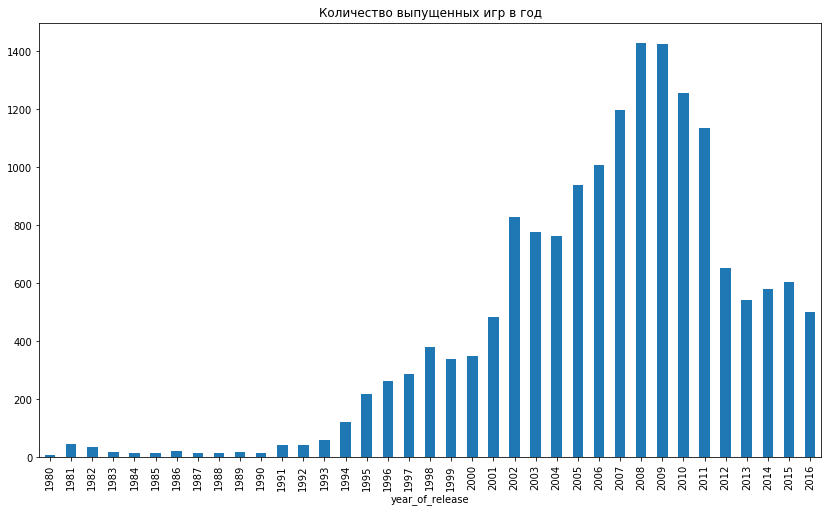

In [24]:
games.groupby('year_of_release')['name'].count().plot(kind='bar', 
                                                      y='year_of_release', title='Количество выпущенных игр в год', 
                                                      figsize=(14, 8))

С 2002 года наметился заметный рост количества выпускаемых игр, который достиг своего пика в 2008-2009 годах. Затем ежегодный выпуск игр пошел на спад. С 2013 наблюдается стабильность: количество выпускаемых игр держится на приблизительно одиноковом уровне.

### Анализ платформ <a id="platform" ></a>

Рассмотрим суммарные продажи игр по каждой из платформ.

In [25]:
games.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
PC       255.72
GB       254.43
XB       251.57
NES      251.05
N64      218.01
SNES     200.04
GC       196.73
XOne     159.32
2600      86.48
WiiU      82.19
PSV       53.81
SAT       33.59
GEN       28.35
DC        15.95
SCD        1.86
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: total_sales, dtype: float64

Выберем шесть платфом с самыми большими продажами и сохраним данные по ним в переменной `pop_platform`.

In [26]:
platform = games.groupby('platform')['total_sales'].sum().sort_values(ascending=False).iloc[0:6]
pop_platform = games.query('platform in @platform.index')
pop_platform.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91


Посмотрим, как распределялись продажи игр по годам для этих шести платформ. Для этого сохраним в переменной `pivot_pop_platform` сводную таблицу с cуммарными продажами за каждый год, а затем построим столбчатый график с ежегодными продажами для каждой платформы.

In [27]:
pivot_pop_platform = pop_platform.pivot_table(index=['platform','year_of_release'], values='total_sales', 
                                aggfunc='sum').reset_index().rename_axis(None, axis=1)
pivot_pop_platform.head()

,platform,year_of_release,total_sales
0,DS,1985,0.02
1,DS,2004,17.27
2,DS,2005,130.14
3,DS,2006,119.81
4,DS,2007,146.94


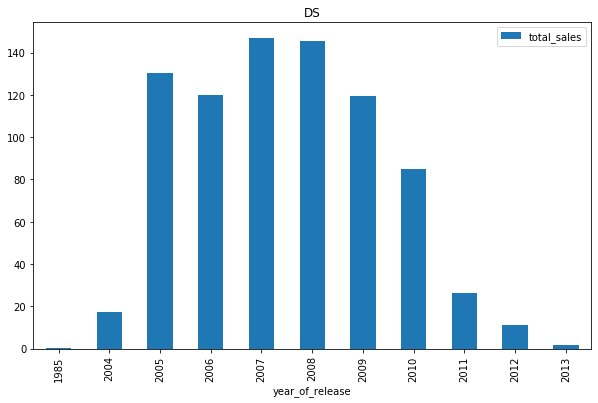

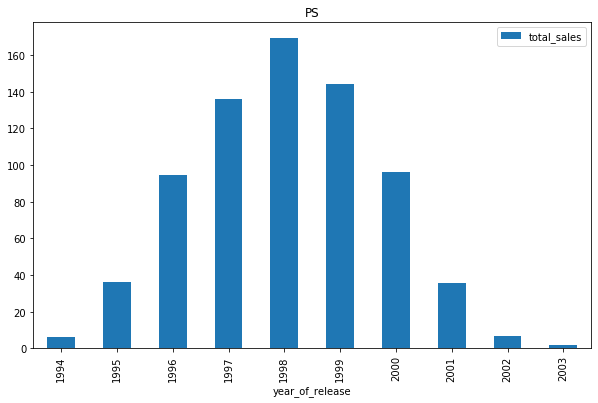

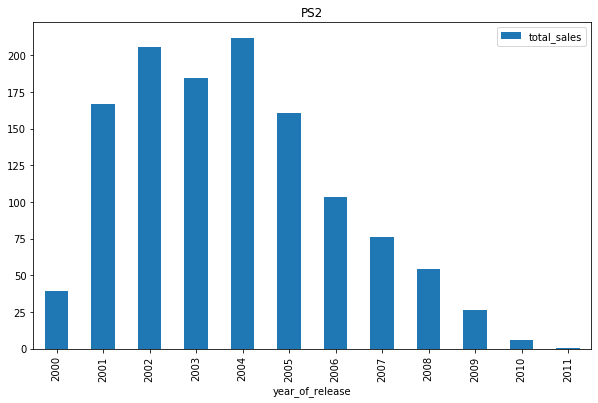

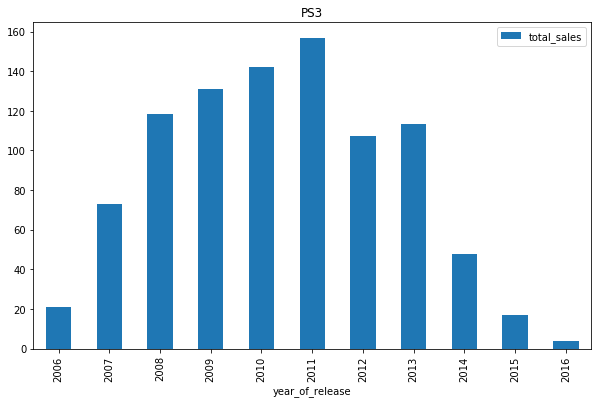

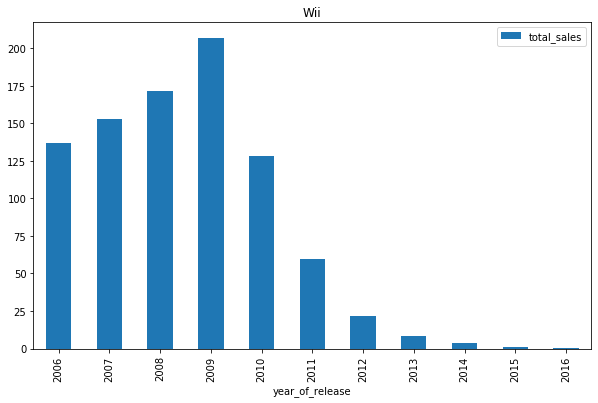

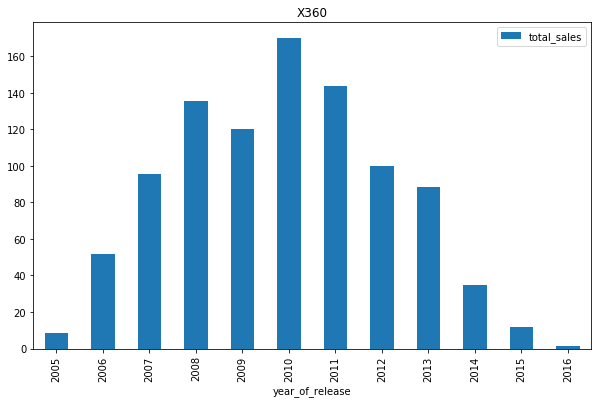

In [28]:
for platform, group in pivot_pop_platform.groupby('platform'):
    group.plot(kind='bar', x='year_of_release', figsize=(10, 6), title=platform)

Из увиденного можно сделать вывод, что в среднем срок жизни платформы составляет 10 лет, при этом пик продаж игр для нее приходится на пятый год. Для прогноза на 2017 год нужно определить, для каких платфом этот год будет пятым годом присутсвия на рынке. Возьмем небольшой запас и для исследования выберем игры, выпущенные с 2010 года. Сохраним соответствующий срез в переменной `act_games`.

In [29]:
act_games = games.query('year_of_release >= 2010')
act_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
14,Kinect Adventures!,X360,2010,Misc,15.00,4.89,0.24,1.69,61.0,6.3,E,21.82
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
27,Pokemon Black/Pokemon White,DS,2010,Role-Playing,5.51,3.17,5.65,0.80,NaN,NaN,unknown,15.13
29,Call of Duty: Modern Warfare 3,X360,2011,Shooter,9.04,4.24,0.13,1.32,88.0,3.4,M,14.73


In [30]:
act_games.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,2311.000000,2498.000000,5276.000000
mean,2012.357657,0.214255,0.159435,0.057835,0.050696,70.457378,6.678263,0.482221
std,2.034494,0.613145,0.464231,0.227132,0.150650,13.563632,1.521517,1.236085
min,2010.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.200000,0.010000
25%,2011.000000,0.000000,0.000000,0.000000,0.000000,62.000000,5.900000,0.040000
50%,2012.000000,0.050000,0.020000,0.000000,0.010000,73.000000,7.000000,0.130000
75%,2014.000000,0.172500,0.130000,0.040000,0.040000,80.000000,7.800000,0.400000
max,2016.000000,15.000000,9.090000,5.650000,3.960000,97.000000,9.300000,21.820000


Посмотрим, как распределялись продажи игр по годам внутри актуальног периода для каждой из платформ. Для этого сохраним в переменной `act_platform` сводную таблицу с cуммарными продажами за каждый год, а затем построим столбчатый график с ежегодными продажами для каждой платформы.

In [31]:
act_platform = act_games.pivot_table(index=['platform','year_of_release'], values='total_sales', 
                                aggfunc='sum').reset_index().rename_axis(None, axis=1)
act_platform.head()

,platform,year_of_release,total_sales
0,3DS,2011,63.20
1,3DS,2012,51.36
2,3DS,2013,56.57
3,3DS,2014,43.76
4,3DS,2015,27.78


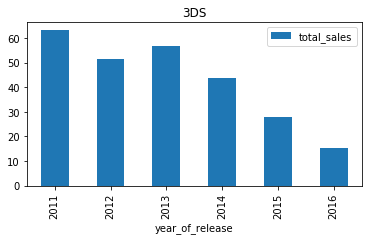

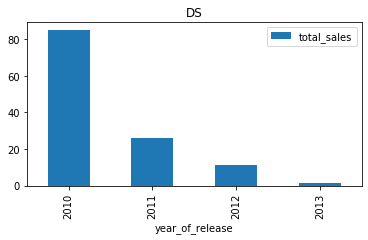

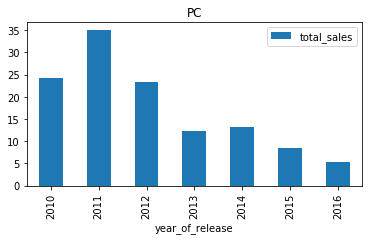

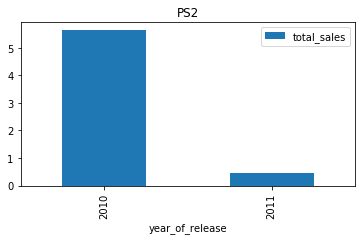

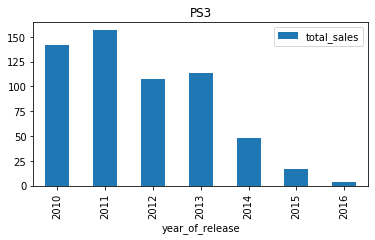

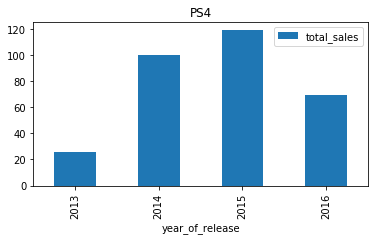

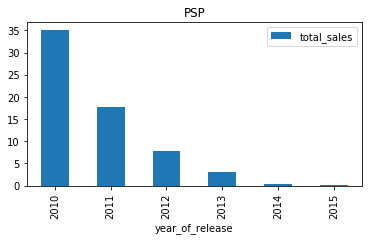

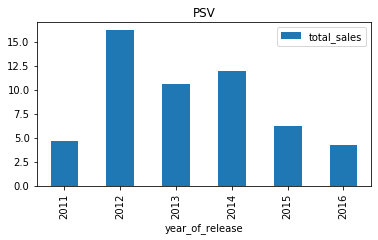

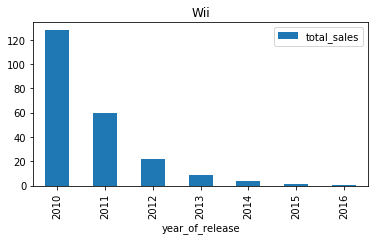

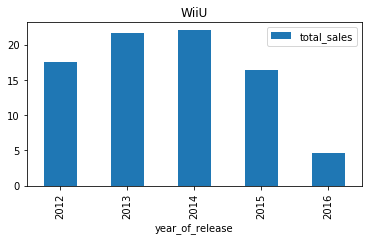

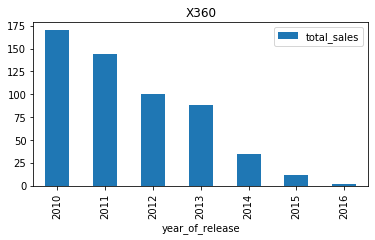

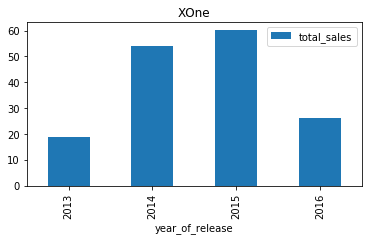

In [32]:
for platform, group in act_platform.groupby('platform'):
    group.plot(kind='bar', x='year_of_release', figsize=(6, 3), title=platform)

Построим обзорный график, на котором представлены продажи по всем платформам за актуальный период.

Text(0.5, 1.0, 'Суммарные продажи по всем платформам за актуальный период')

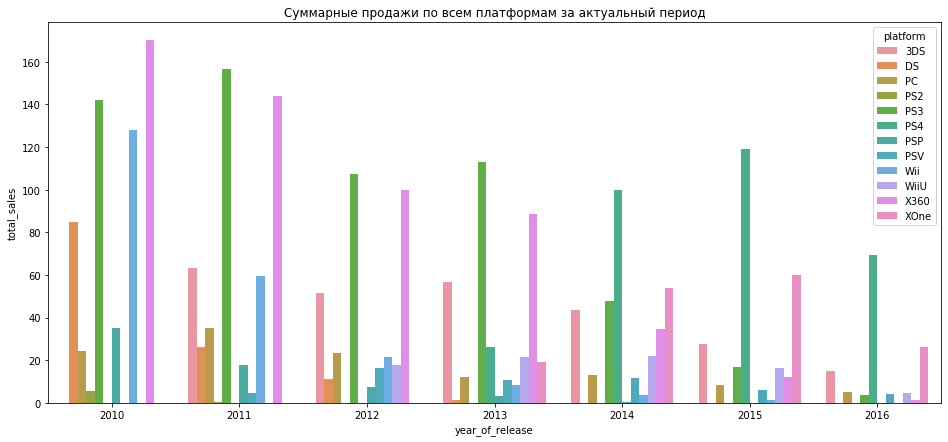

In [33]:
plt.figure(figsize=(16, 7))
sns.barplot(x="year_of_release", y="total_sales", hue="platform", data=act_platform)
plt.title('Суммарные продажи по всем платформам за актуальный период')

Видно, что продажами выделяются игры для консолей от **Microsoft** (семейство `Xbox`) и **Sony** (семейство `PlayStation`). В начале периода конкуренцию им составляла `Wii` от **Nintendo**, но новое поколение консоли `WiiU` уже не было таким популярным. Перспективными платформами являются `PS4` и `XOne`, пришедшие на смену `PS3` и `X360` соответственно. 2017 год будет пятым годом существования этих платформ, и можно ожидать пика продаж игр для них.

Посмотрим диаграммы размаха продаж игр для каждой из платформ.

Text(0.5, 1.0, 'Диаграмма размаха продаж игр для каждой из платформ')

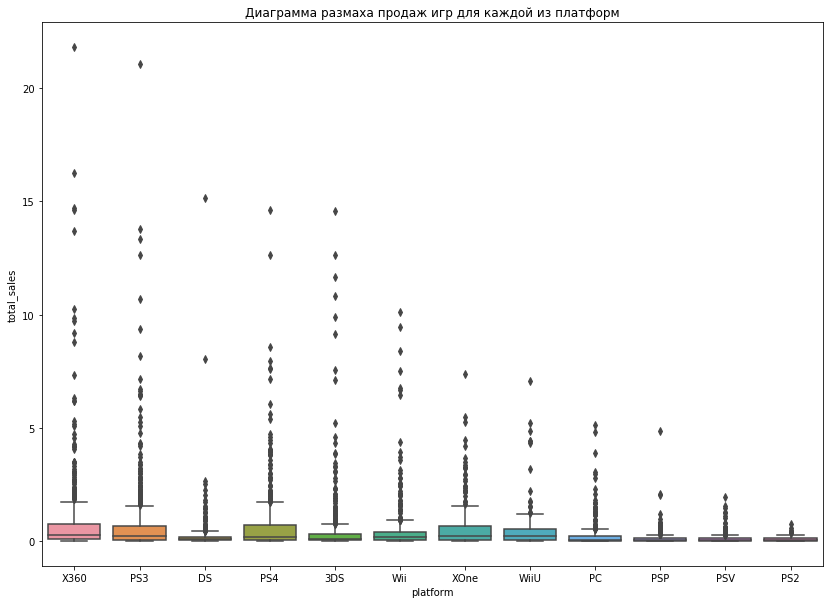

In [34]:
plt.figure(figsize=(14, 10))
sns.boxplot(data=act_games, x="platform", y="total_sales")
plt.title('Диаграмма размаха продаж игр для каждой из платформ')

Для `X360` и `PS3` были игры с рекордными продажами. Посмотрим нижнюю часть графика подробнее, ограничив продажи 5 млн.

Text(0.5, 1.0, 'Диаграмма размаха продаж игр для каждой из платформ')

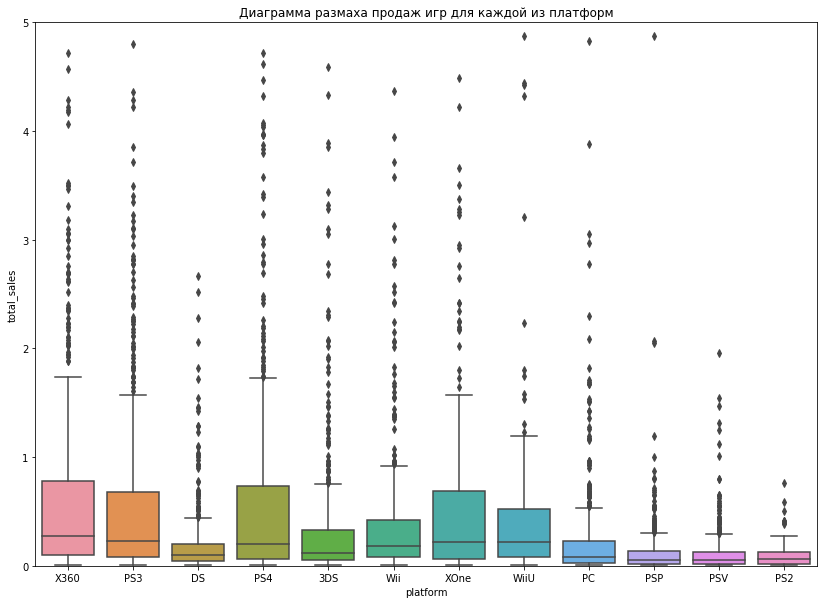

In [35]:
plt.figure(figsize=(14, 10))
sns.boxplot(data=act_games, x="platform", y="total_sales")
plt.ylim(0, 5)
plt.title('Диаграмма размаха продаж игр для каждой из платформ')

Для платформ от **Microsoft** и **Sony** и межквартильные интервалы, и "усы" достаточно близки по своим размерам. Разброс продаж для них выше, чем для остальных платформ, выбросы встречаются чаще, а их размер больше. Игры, выпускаемые для этих платформ, продаются в больших количествах и чаще становятся хитами.

### Анализ оценок критиков и пользователей <a id="score" ></a>

Изучим **зависимость продаж от оценок пользователей и критиков**. Построим соответствующие диаграммы размаха и посчитаем коэффициенты Пирсона для игр, выщедших на **PlayStation4**.

In [36]:
def plot1(platform):
    act_games.loc[act_games['platform'] == platform].plot(kind='scatter', x='critic_score', y='total_sales',
                                                        alpha=0.45, figsize=(12, 5), grid=True, legend=True,
                                                         title='Зависимость продаж от оценки критиков')
    
    act_games.loc[act_games['platform'] == platform].plot(kind='scatter', x='user_score', y='total_sales',
                                                        alpha=0.45, figsize=(12, 5), grid=True, legend=True,
                                                         title='Зависимость продаж от оценки пользователей')
    
    print('Корреляция между продажами и оценками критиков: {:.2f}'.format(act_games.loc[act_games['platform'] == platform]['critic_score'].
                                               corr(act_games.loc[act_games['platform'] == platform]['total_sales'])))
    print('Корреляция между продажами и оценками пользователей: {:.2f}'.format(act_games.loc[act_games['platform'] == platform]['user_score'].
                                               corr(act_games.loc[act_games['platform'] == platform]['total_sales'])))

Корреляция между продажами и оценками критиков: 0.41
Корреляция между продажами и оценками пользователей: -0.03


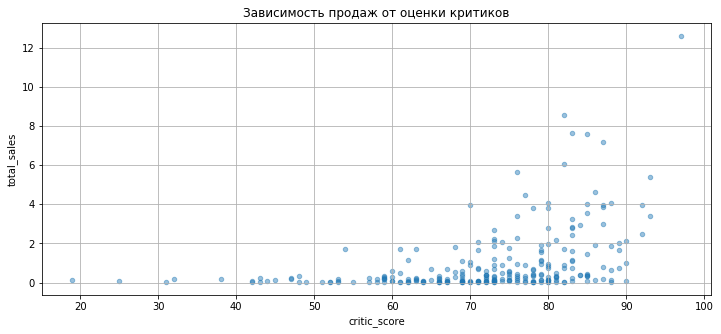

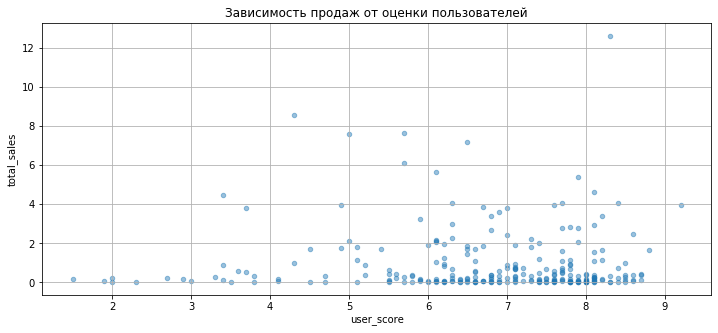

In [37]:
plot1('PS4')

Продажи игр слабо зависят от оценки критиков, а вот от оценки пользователей не зависят вовсе. Посмотрим, какие были зависимости для предыдущего поколения платформы от Sony **PS3**.

Корреляция между продажами и оценками критиков: 0.40
Корреляция между продажами и оценками пользователей: 0.07


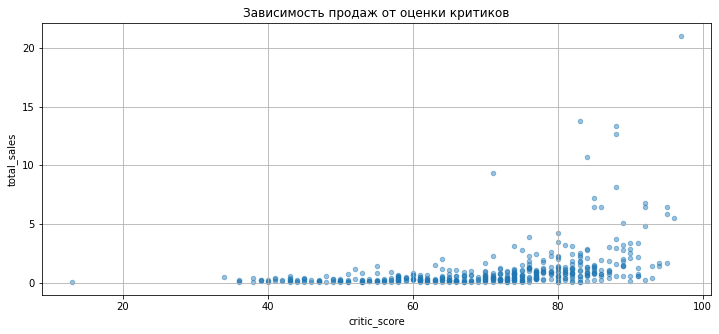

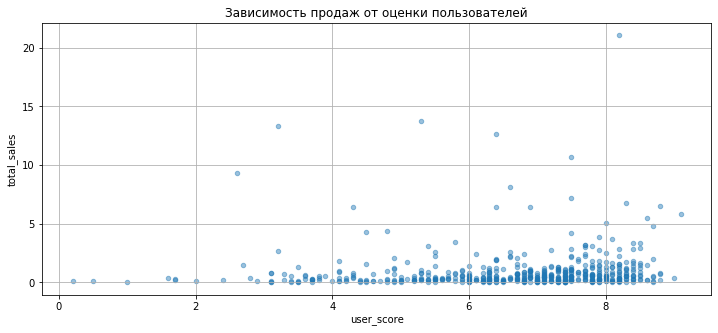

In [38]:
plot1('PS3')

То же самое. А что у конкурентов из Microsoft?

Корреляция между продажами и оценками критиков: 0.42
Корреляция между продажами и оценками пользователей: -0.07


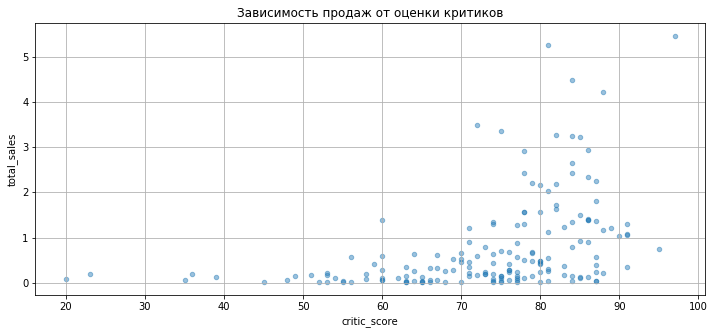

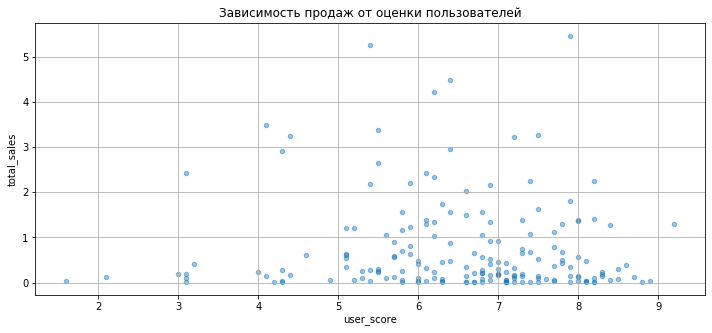

In [39]:
plot1('XOne')

Примерно тоже самое. Можно сказать, что данные зависимости сохраняются для все популярных платформ.

### Анализ жанров <a id="genre" ></a>

Посмотрим зависимость продаж от жанра игры. Построим соответствующий столбчатый график.

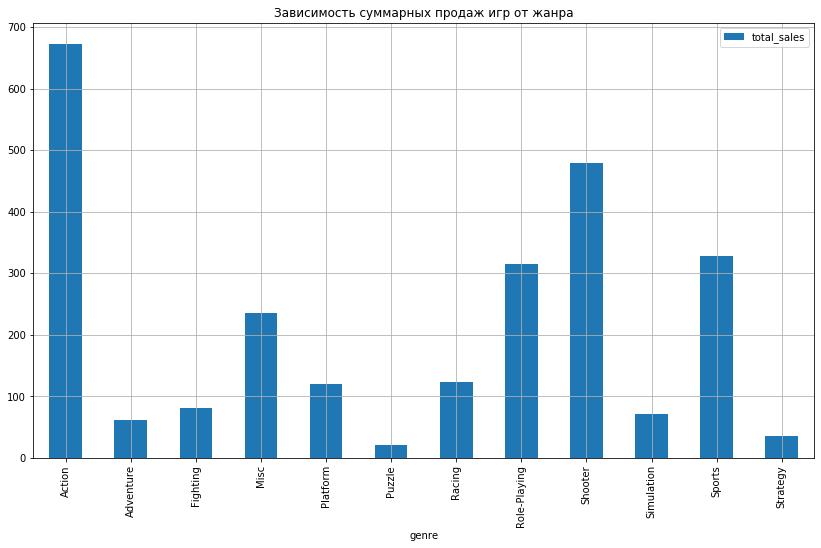

In [40]:
act_games.pivot_table(index='genre', values='total_sales', aggfunc='sum').plot(y='total_sales', kind='bar', grid=True, figsize=(14, 8),
                                                                      title='Зависимость суммарных продаж игр от жанра')

Компьютерные игры жанра **Action** лидируют по продажам, так же выделяются шутеры, спортивные симуляторы и RPG. А вот игры жанра **Puzzle** продаются меньше всех.

Посмотрим, как продается средняя игра каждого жанра.

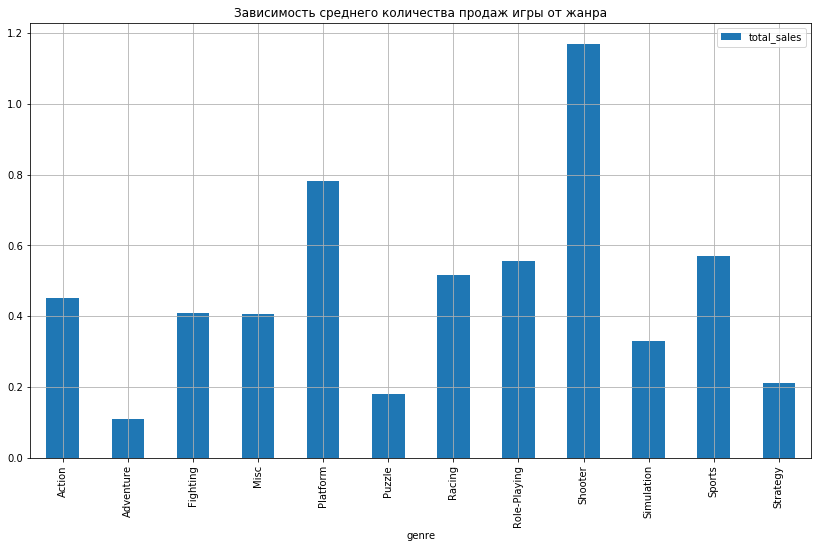

In [41]:
act_games.pivot_table(index='genre', values='total_sales').plot(y='total_sales', kind='bar', grid=True, figsize=(14, 8),
                                                                      title='Зависимость среднего количества продаж игры от жанра')

Средний шутер продается больше остальных. А вот жанр **Action** потерял здесь свое лидерство. Видимо на общие продажи влияет большое количество выпускаемых в этом жанре игр.

### Вывод

В результате проведенного анализа можно сказать следующее:
1. Продажи игр в последние годы снизились.
2. Срок жизни платформ составляет в седнем 10 лет, а пик продаж игр для этой платформы приходипся на пятый год.
3. Актуальным периодом для исследования можно считать последние 6 лет.
4. Лидерами продаж являются игры для консолей от Microsoft и Sony, соответственно перспективными платформами являются консоли последнего поколения от этих производителей.
5. Продажи игр слабо зависят от оценок критиков и почти не зависят от оценок пользователей.
6. Игры-шутеры продаются самыми большими тиражами, а жанр Acnion лидирует по суммарным продажам из-за своей массовости.

[В начало раздела](#analysis)

[К оглавлению](#contents)

## 4. Составление портрета пользователя каждого региона <a id="portrait" ></a>

Составим портрет пользователя каждого региона, выделив топ-5 платформ и топ-5 жанров для них. Отразим результаты на круговых диаграммах.

Создадим функцию, которая на вход получает названия столбцов с объектом исследования (в нашем случае платформы и жанры) и продажами в регионе, а возвращает круговую диаграмму с топ-5 объектами. При этом внутри функции объекты, не вошедшие в топ-5 выделим в группу "Остальные". Ее тоже отразим на диаграмме.

In [42]:
def pie_port(obj, reg_sales):
    a = act_games.groupby(obj)[reg_sales].sum().sort_values(ascending=False).iloc[0:5]
    b = act_games
    def x(c):
        if c not in a.index:
            return 'Остальные'
        return c
    b['top'] = b[obj].apply(x)
    b.groupby('top')[reg_sales].sum().sort_values(ascending=False).iloc[0:5].plot(y=reg_sales, kind='pie',
                                    figsize=(8, 8), autopct='%1.1f%%', shadow=True, explode=(0.1, 0, 0.15, 0, 0.17),
                                                            wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"}, rotatelabels=True)

### Топ-5 платформ каждого региона <a id="t_pl" ></a>

Выделим топ-5 платформ в **Северной Америке**.

Text(0.5, 1.0, 'Топ-5 платформ на рынке Северной Америки')

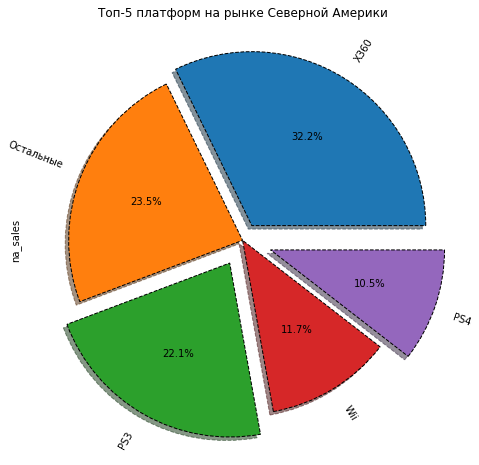

In [43]:
pie_port('platform', 'na_sales')
plt.title('Топ-5 платформ на рынке Северной Америки')

Игры для топ-5 платформ Северной Америки составляют 76.5% всех продаж. Пользователи отдают предпочтение местной X360, остальные места распределились между консолями от **Sony** и **Nintendo**.

Рассмотрим **Европу**.

Text(0.5, 1.0, 'Топ-5 платформ на рынке Европы')

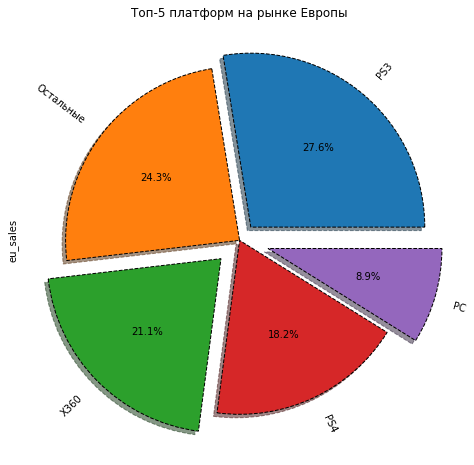

In [44]:
pie_port('platform', 'eu_sales')
plt.title('Топ-5 платформ на рынке Европы')

Игры для топ-5 платформ Европы составляют 75.7% всех продаж. Пользователи отдают предпочтение консолям от **Sony**, игры  для двух поколений которых составляют более 45% всех продаж. Так же пользуются спросом игры для персональных компьютеров, чего не было в Северной Америке.

Изучим топ-5 платформ **Японии**.

Text(0.5, 1.0, 'Топ-5 платформ на рынке Японии')

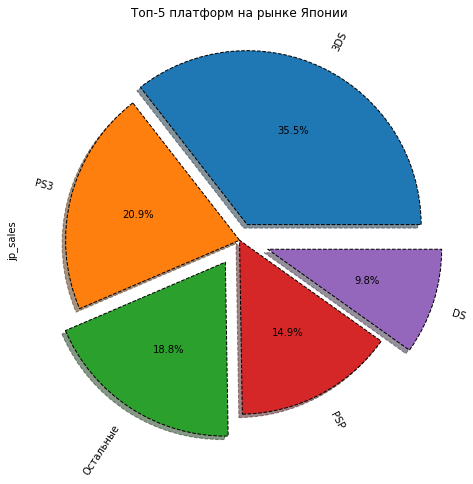

In [45]:
pie_port('platform', 'jp_sales')
plt.title('Топ-5 платформ на рынке Японии')

Игры для топ-5 платформ Японии составляют 81.2% всех продаж. И все эти платформы местного производства - консоли от **Sony** и **Nintendo**. Причем пользователи отдают предпочтение портативным консолям, игры  для которых составляют чуть более 60% всех продаж.

### Топ-5 жанров каждого региона <a id="t_gen" ></a>

Рассмотрим **Северную Америку**.

Text(0.5, 1.0, 'Топ-5 жанров на рынке Северной Америки')

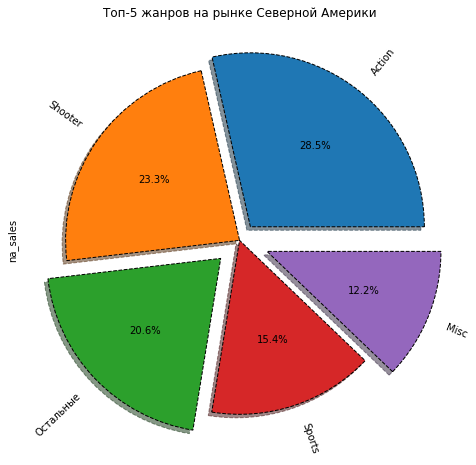

In [46]:
pie_port('genre', 'na_sales')
plt.title('Топ-5 жанров на рынке Северной Америки')

Игры для топ-5 жанров Северной Америки составляют 79.4% всех продаж. Пользователи отдают предпочтение играм жанров *Action* и *Shooter*, которые составляют более 50% всех продаж. Так же в топ-5 спортивные симуляторы и игры смешанного жанра.

Рассмотрим **Европу**.

Text(0.5, 1.0, 'Топ-5 жанров на рынке Европы')

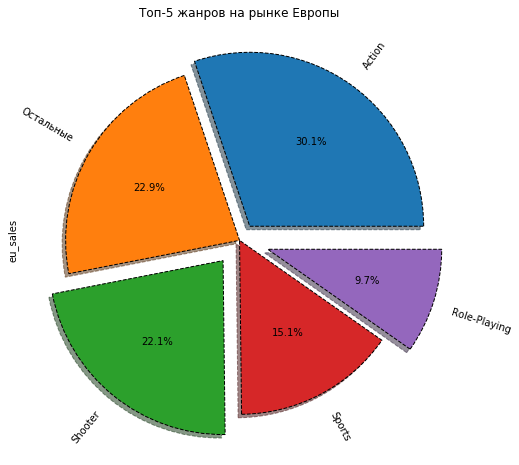

In [47]:
pie_port('genre', 'eu_sales')
plt.title('Топ-5 жанров на рынке Европы')

Игры для топ-5 жанров Европы составляют 77.1% всех продаж. Пользователи так же, как и в Северной Америке, отдают предпочтение играм жанров Action и Shooter, которые составляют более 50% всех продаж. Однако в Европе в топ-5  кроме спортивных симуляторов  попали ролевые игры.

Рассмотрим **Японию**.

Text(0.5, 1.1, 'Топ-5 жанров на рынке Японии')

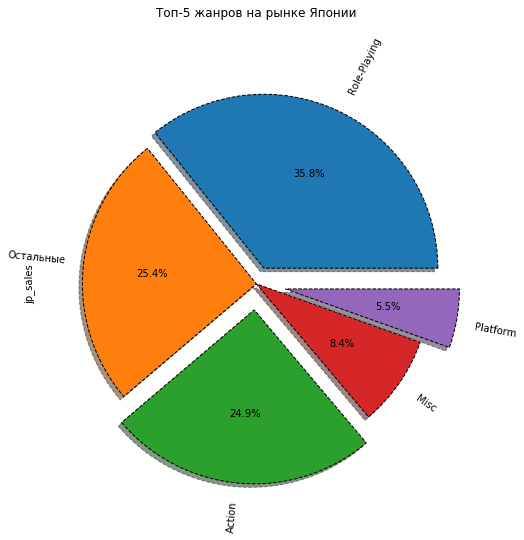

In [48]:
pie_port('genre', 'jp_sales')
plt.title('Топ-5 жанров на рынке Японии', y=1.1)

Игры для топ-5 жанров Европы составляют 74.6% всех продаж. Пользователи отдают предпочтение ролевым играм (35,8%), так же в топ-5 вошли игры жанров *Action, Misc, Platform*.

### Зависимость продаж в отдельном регионе от рейтинга ESRB  <a id="ESRB" ></a>

Изучим зависимость продаж в отдельном регионе от рейтинга ESRB с помощью столбчатого графика, отражающего количество проданных игр каждой категории в каждом регионе.

In [49]:
rating = act_games.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum').reset_index().rename_axis(None, axis=1)
rating

,rating,eu_sales,jp_sales,na_sales
0,E,197.34,47.87,271.15
1,E10+,99.28,13.22,159.38
2,EC,0.00,0.00,1.13
3,M,292.04,30.45,382.22
4,T,113.08,42.11,160.81
5,unknown,139.44,171.49,155.72


<Figure size 1008x720 with 0 Axes>

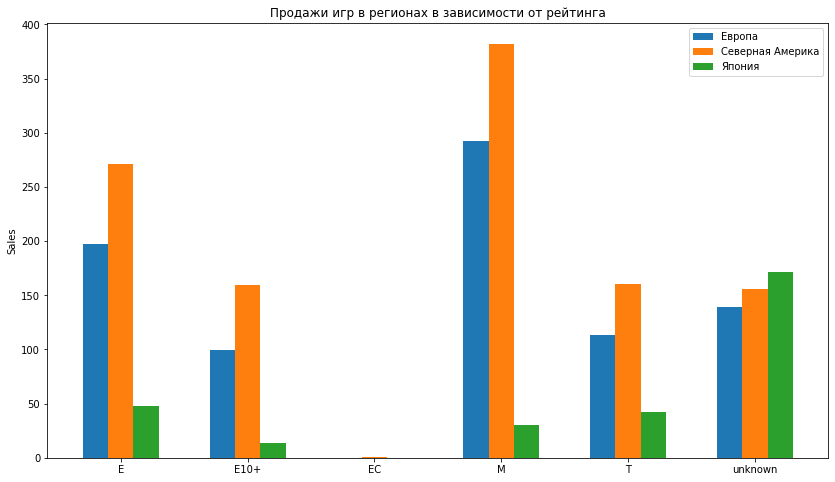

In [50]:
x = np.arange(len(rating['rating']))
width = 0.2
plt.figure(figsize=(14, 10))
fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/1, rating['eu_sales'], width, label='Европа')
rects2 = ax.bar(x, rating['na_sales'], width, label='Северная Америка')
rects2 = ax.bar(x + width/1, rating['jp_sales'], width, label='Япония')
ax.set_ylabel('Sales')
ax.set_title('Продажи игр в регионах в зависимости от рейтинга')
ax.set_xticks(x)
ax.set_xticklabels(rating['rating'])
ax.legend()

В Америке и Европе больше всего продано игр с рейтингом «M» («Mature») — «Для взрослых». Это логично, так как там популярны шутеры, для которых характерна определенная жестокость. А вот в Японии игры с рейтингом «M» популярностью не пользуются. Там большинство проданных игр с рейтингом «Unknown». Это можно объяснить тем, что для продажи на территории Японии рейтинг играм присваивает местная *CERO*, а он в таблице не отражен.

### Вывод

По итогам исследования региональных продаж можно составить следующие портреты пользователей:
1. Жители Северной Америки предпочитают играть на игровых приставках (местный Xbox популярнее PS) в шутеры и экшены с рейтингом «M».
2. Жители Европы предпочитают играть на игровых приставках фирмы *Sony* в те же шутеры и экшены, но не оставляют без внимания и проекты для ПК.
3. Жители Японии предпочитают играть на местных портативных консолях в ролевые игры, рейтинг которым присваивает местная *CERO*.

[В начало раздела](#portrait)

[К оглавлению](#contents)

## 5. Проверка гипотез <a id="check" ></a>

Необходимо проверить две гипотезы:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action и Sports разные.

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые <a id="xone_or_pc" ></a>

Рассмотрим рапределение пользовательских оценок для платформ Xbox One и PC. 

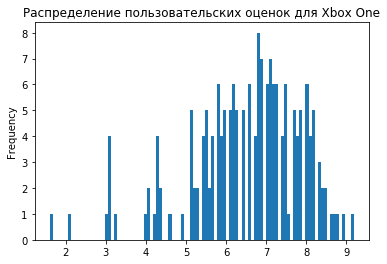

In [51]:
xone_u_s = act_games.query('platform in "XOne"')
xone_u_s['user_score'].plot(kind='hist', bins=100, title='Распределение пользовательских оценок для Xbox One')

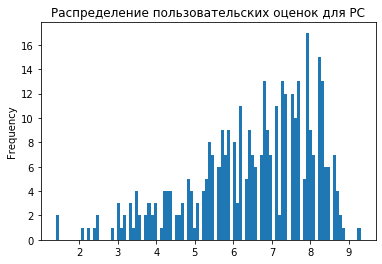

In [52]:
pc_u_s = act_games.query('platform in "PC"')
pc_u_s['user_score'].plot(kind='hist', bins=100, title='Распределение пользовательских оценок для PC')

Оба распределения отличаются от нормального и смещены вправо. Поэтому для проверки гипотезы применим U-критерий Манна — Уитни. Сформулируем нулевую гипозезу: **"Средние пользовательские рейтинги платформ Xbox One и PC одинаковые"**, и проведем тест. 

In [53]:
def mwtest(array1, array2):
    
    alpha = .05
 
    results = st.mannwhitneyu(array1, array2) 
        

    print('p-значение:', results.pvalue)

    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [54]:
mwtest(xone_u_s['user_score'], pc_u_s['user_score'])

p-значение: 0.1709764757774625
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что хотя cредние пользовательские рейтинги платформ Xbox One и PC и неодинаковы, с вероятностью в более чем 17% такое или большее различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними пользовательскими рейтингами платформ Xbox One и PC. Одни и те же игры могут выпускаться на разных платформах, при этом имея примерно одинаковые рейтинги.

### Средние пользовательские рейтинги жанров Action и Sports разные <a id="ac_or_sp" ></a>

Рассмотрим рапределение пользовательских оценок для жанров Action и Sports.

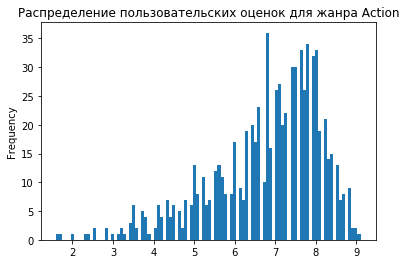

In [55]:
action_u_s = act_games.query('genre in "Action"')
action_u_s['user_score'].plot(kind='hist', bins=100, title='Распределение пользовательских оценок для жанра Action')

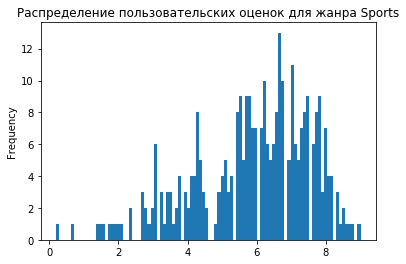

In [56]:
sports_u_s = act_games.query('genre in "Sports"')
sports_u_s['user_score'].plot(kind='hist', bins=100, title='Распределение пользовательских оценок для жанра Sports')

Оба распределения отличаются от нормального и смещены вправо. Поэтому для проверки гипотезы применим U-критерий Манна — Уитни. Сформулируем нулевую гипозезу: **"Средние пользовательские рейтинги жанров Action и Sports одинаковые"**, и проведем тест.

In [57]:
mwtest(action_u_s['user_score'], sports_u_s['user_score'])

p-значение: 1.7533265278574778e-27
Отвергаем нулевую гипотезу


Нулевая гипотеза слишком маловероятна. Средние пользовательские рейтинги жанров Action и Sports действительно разные.

### Вывод

Обе гипотезы, предложенные для проверки, оказались подверждены.

[В начало раздела](#check)

[К оглавлению](#contents)

## 6. Общий вывод <a id="conclusion"></a> 

### Краткий обзор проведенной работы

В данном проекте мы получили данные о продажах компьютерных игр, начиная с 1980 года. Выполнили их подготовку:
- привели названия столбцов к нижнему регистру;
- удалили пропуски для столбцов *'name'* и *'year_of_release'*;
- значение "tbd" в столбце с оценками пользователей заменили на "NaN";
- пропущенные значения столбца *'rating'* заменили на *unknown*.
- посчитали и занесли в таблицу суммарные продажи для каждой игры.

В дальнейшем провели анализ обработанных данных, определив популярные платформы и жанры, а также влияние оценок пользователей и критиков на продажи. Сформировали портрет пользователя отдельного региона и проверили предложенные гипозы, проведя U-тест Манна-Уитни.

### Главные выводы

Изучив данные о продажах компьютерных игр, можно сказать следующее:
1. Продажи компьютерных игр упали вдвое по сравнению с пиком, показанным в 2008-2009 годах.
2. Срок жизни платформы составляет в среднем 10 лет, пик продаж игр для этой платформы приходится на пятый год.
3. Актуальным периодом для исследования можно считать последние 6 лет.
4. Лидерами продаж являются игры для консолей от Microsoft и Sony, соответственно перспективными платформами являются консоли последнего поколения от этих производителей (Xbox One и PS4).
5. Продажи игр слабо зависят от оценок критиков и почти не зависят от оценок пользователей.
6. Игры-шутеры продаются самыми большими тиражами, а жанр Acnion лидирует по суммарным продажам из-за своей массовости.
7. Жители Северной Америки предпочитают играть на игровых приставках (местный Xbox популярнее PS) в шутеры и экшены с рейтингом «M».
8. Жители Европы предпочитают играть на игровых приставках фирмы *Sony* в те же шутеры и экшены, но не оставляют без внимания и проекты для ПК.
9. Жители Японии предпочитают играть на местных портативных консолях в ролевые игры, рейтинг которым присваивает местная *CERO*.
10. Средние пользовательские рейтинги платформ Xbox One и PC действительно одинаковые.
11. Средние пользовательские рейтинги жанров Action и Sports действительно разные.

На количество продаж игры влияют платформа, на которой она выходит, жанр и оценки критиков в меньшей степени.

### Рекомендации

Потенциально успешными проектами в 2017 году могут быть игры жанров Action и Shooter, выходящие на современных консолях от Microsoft и Sony (Xbox One и PS4), поэтому в планировании рекламной кампании нужно ориентироваться на них. При этом реклама должна ориентироваться на регион продаж, так как предпочтения игроков в разных регионах отличаются.

[В начало раздела](#conclusion)

[К оглавлению](#contents)